In [10]:
import scanpy as sc
import pandas as pd

sample_id = "IMMUNEX001"
base_path = f"/scratch/IMMUNEX/OUTPUT/Visium_NSCLC_{sample_id}/outs/binned_outputs/square_002um"

# Load expression
adata = sc.read_10x_h5(f"{base_path}/filtered_feature_bc_matrix.h5", gex_only=True)

# Load and attach spatial coordinates
spatial = pd.read_parquet(f"{base_path}/spatial/tissue_positions.parquet")

spatial.set_index("barcode", inplace=True)
adata.obs = adata.obs.join(spatial, how="left")
adata.obsm["spatial"] = adata.obs[["pxl_col_in_fullres", "pxl_row_in_fullres"]].values

adata

/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 10822530 × 18536
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'

In [2]:
from PIL import Image
import numpy as np

# Path to original H&E
img_path = "/scratch/IMMUNEX/PJ2410310_250214/IMAGE/HE_nanozoomer_tif/IMMUNEX001_Visium_HE_x40_z0.tif"

# Load and downscale
img = Image.open(img_path)
img_lowres = img.resize((img.width // 8, img.height // 8))  # 8x smaller

# Convert to numpy
img_lowres_np = np.array(img_lowres)


DecompressionBombError: Image size (10940252160 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.

In [4]:
adata.uns["spatial"] = {
    "IMMUNEX001": {
        "images": {"lowres": img_lowres_np},
        "scalefactors": {
            "tissue_lowres_scalef": 1.0  # you can calibrate if needed
        },
        "metadata": {
            "source_image_path": img_path
        }
    }
}


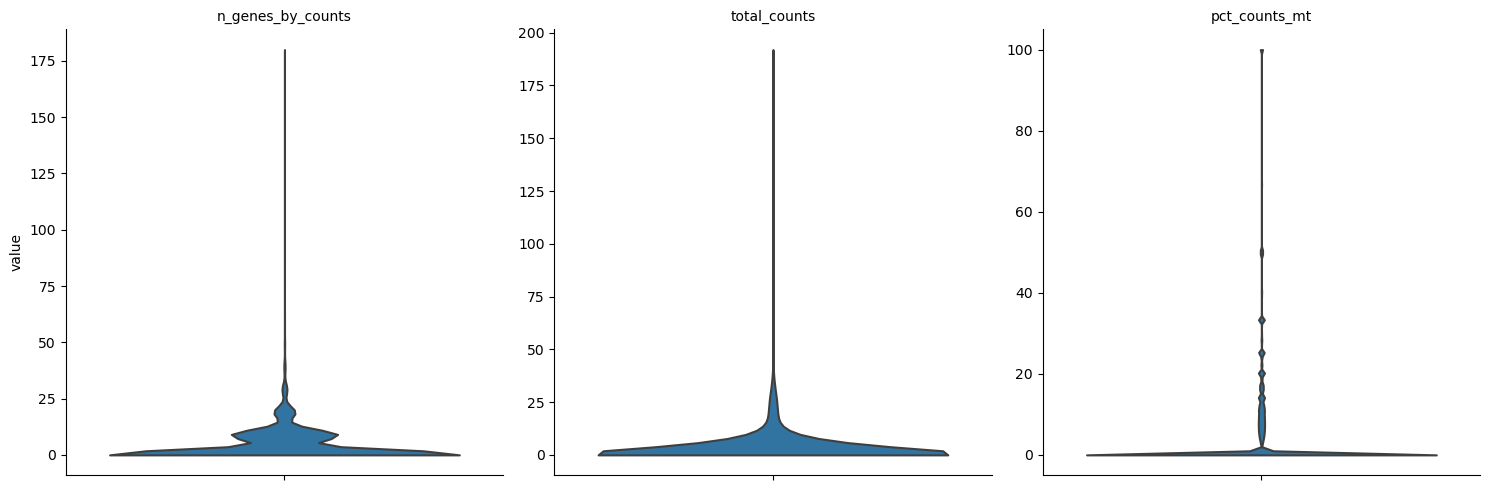

In [11]:
# Mitochondrial genes
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

adata.var_names_make_unique()
adata.raw = adata.copy()
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=1, multi_panel=True, stripplot=False )


In [6]:
# Quality filter
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata = adata[adata.obs["total_counts"] > 1, :]

# Normalize + log + select HVGs
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=250)
adata = adata[:, adata.var.highly_variable]
adata

/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


View of AnnData object with n_obs × n_vars = 8287600 × 250
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg'
    obsm: 'spatial'

In [12]:
import squidpy as sq

# Compute spatial neighbors (radius-based is better for binned data)
sq.gr.spatial_neighbors(adata, coord_type="grid", radius=20)  # 20px ~ 40 µm
adata

ModuleNotFoundError: No module named 'squidpy'

In [13]:
sq.gr.spatial_autocorr(adata, mode="moran") 
sc.tl.leiden(adata, resolution=0.3, key_added="spatial_leiden",obsp="spatial_connectivities")


NameError: name 'sq' is not defined

In [41]:
adata.uns["spatial"] = backup_spatial

/tmp/ipykernel_3183192/3465105705.py:12: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values):


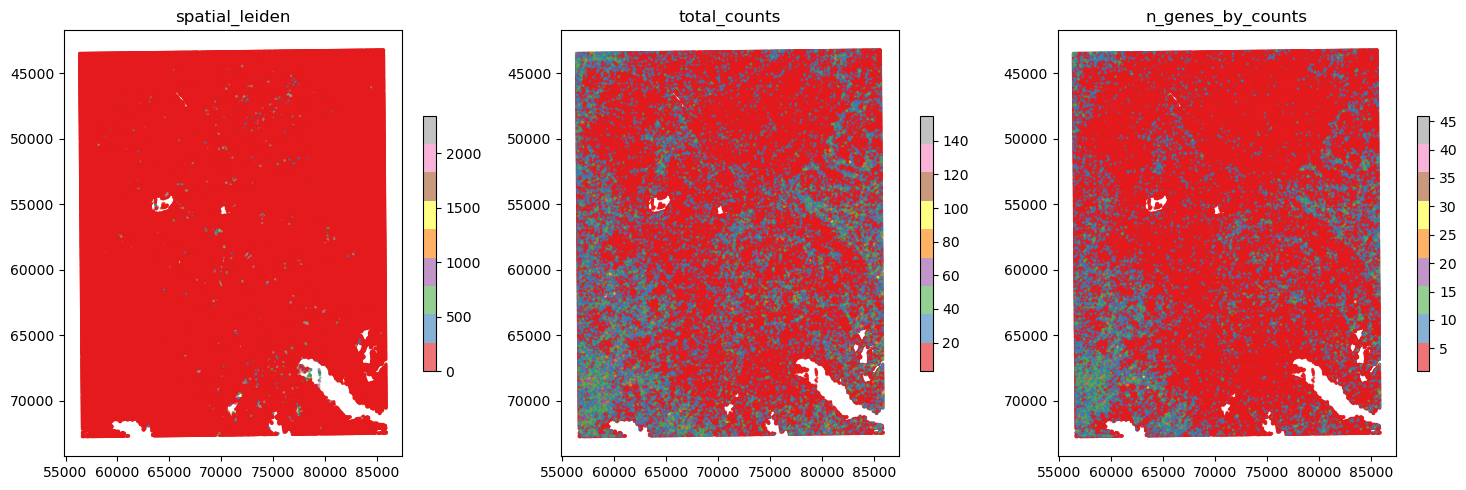

In [45]:
import matplotlib.pyplot as plt

coords = adata.obsm["spatial"]
features = ["spatial_leiden", "total_counts", "n_genes_by_counts"]

fig, axes = plt.subplots(1, len(features), figsize=(5 * len(features), 5))

for ax, feature in zip(axes, features):
    values = adata.obs[feature]
    
    # Handle categorical labels by converting to integers
    if pd.api.types.is_categorical_dtype(values):
        values = values.cat.codes

    sc = ax.scatter(
        coords[:, 0], coords[:, 1],
        c=values,
        cmap="Set1",
        s=1, alpha=0.6
    )
    ax.set_title(feature)
    ax.invert_yaxis()
    plt.colorbar(sc, ax=ax, shrink=0.6)

plt.tight_layout()
plt.show()
